In [1]:
MAIN_PATH = "/home/carlos/MasterDS/tfm"
JSON_DATA_PATH = '{}/data/json/'.format(MAIN_PATH)
CSV_DATA_PATH = '{}/data/csv/'.format(MAIN_PATH)

In [2]:
import sys
sys.path.insert(0, MAIN_PATH)

In [3]:
%load_ext autoreload
%autoreload 2
from scripts.models.ltr_gbt.train import LTRGBTTrain
from scripts.models.ltr_gbt.metrics import LTRGBTMetrics

%reload_ext autoreload

# Entrenamiento

Para encontrar los mejores hiperparámetros de gbt (https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)

1. Elegimos un learning rate alto: 0.1
2. Escogemos el número óptimo de árboles para esta tasa
3. Para esa tasa y número de estimadores, elegimos los mejores parámetros
de árbol.
4. Bajamos la tasa y subimos el número de estimadores

- Con la primera prueba, se ha estimado que el número óptimo de árboles
es de 80
- Con la segunda prueba, obtenemos min_samples_split=800 y max_depth=9
- Obtenemos también subsample=9 y min_samples_leaf=60

In [4]:
ltr_params = {
    'key_events': ['goal', 'red_card', 'penalty'],
    'lags': [1, 3, 5],
    'target_metric': 'rouge',
    'drop_teams': True,
    'lemma': True,
    'metric_params': {'rouge_mode': 'rouge-1', 'rouge_metric': 'r'},
    'count_vec_kwargs': {'ngram_range': (1, 2), 'strip_accents': 'unicode'}
}
cat_features_dict = {'is_key_event': [0, 1]}
num_features = ['tfidf_sum']
model_params = {
    'min_samples_split': 500,
    'min_samples_leaf': 50,
    'subsample': 0.8,  
    'learning_rate': 0.1
}

In [58]:
LTRGBTTrain = LTRTrain(cat_features_dict=cat_features_dict, num_features=num_features,
                     model_params=model_params, ltr_params=ltr_params)

NameError: name 'LTRTrain' is not defined

In [27]:
# Uncomment if using cv

model_params = {
    'min_samples_leaf': [60],
    'subsample': [0.9],  
    'learning_rate': [0.01],
    'n_estimators': [320],
    'max_depth': [9],
    'min_samples_split': [800]
}
cv = 5
opt_metric = 'neg_mean_squared_error'
ltr_train = LTRGBTTrain(cat_features_dict=cat_features_dict, num_features=num_features,
                     model_params=model_params, ltr_params=ltr_params,
                    cv=cv, opt_metric=opt_metric)


Setting target metric to rouge


In [28]:
%%time
ltr_train.train()

Reading /home/carlos/MasterDS/tfm/data/csv/summaries/ltr/features_targets/341d2aa93d/train.csv
Categorizing n_players...
Computing new length...
Dropping {'sentence_ix', 'n_players', 'sim_previous_5', 'players_importance', 'equalize', 'length', 'score', 'position', 'advantage', 'sim_previous_3', 'n_stop', 'n_players_cat', 'total_length', 'event_ix', 'sim_previous_1', 'json_file', 'url'}
Using cv with 5 folds optimizing neg_mean_squared_error
Training model...
Writing model to /home/carlos/MasterDS/tfm/models/ltr_gbt/e735c66e57/ckpt.pickle
Writing model info to /home/carlos/MasterDS/tfm/models/ltr_gbt/e735c66e57/model_info.pickle
CPU times: user 2min 24s, sys: 131 ms, total: 2min 25s
Wall time: 5min 39s


## Salida

In [18]:
model = ltr_train.read_model()

In [19]:
model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(categories=[[0,
                                                                                              1]],
                                                                                 drop='first'))]),
                                                  ['is_key_event'])])),
                ('model',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(random_state=10),
                              n_jobs=5,
                              param_grid={'learning_rate': [0.05],
                                          'max_depth': [9],
                                          'min_samples_leaf': [60],
                       

In [20]:
model_info = ltr_train.read_model_info()

El número de jugadores no aporta nada

In [21]:
# La salida de mse de una etapa de cv en sklearn es negativa
model_info

{'best_score': -0.014975057551470073,
 'best_params': {'learning_rate': 0.05,
  'max_depth': 9,
  'min_samples_leaf': 60,
  'min_samples_split': 800,
  'n_estimators': 160,
  'subsample': 0.9},
 'model_out':            Gini-importance
 x0_1              0.198801
 tfidf_sum         0.801199}

In [22]:
model_info['model_out']

,Gini-importance
x0_1,0.198801
tfidf_sum,0.801199


## Métricas

In [29]:
ltr_metrics = LTRGBTMetrics(ltr_train)

In [30]:
ltr_metrics.run()

Computing metric for train dataset
Reading /home/carlos/MasterDS/tfm/data/csv/summaries/ltr/features_targets/341d2aa93d/train.csv
Categorizing n_players...
Computing new length...
Dropping {'sentence_ix', 'n_players', 'sim_previous_5', 'players_importance', 'equalize', 'length', 'score', 'position', 'advantage', 'sim_previous_3', 'n_stop', 'n_players_cat', 'total_length', 'event_ix', 'sim_previous_1', 'json_file', 'url'}
Writing metrics to /home/carlos/MasterDS/tfm/models/ltr_gbt/e735c66e57/train_metrics.pickle
Computing metric for validation dataset
Reading /home/carlos/MasterDS/tfm/data/csv/summaries/ltr/features_targets/341d2aa93d/validation.csv
Categorizing n_players...
Computing new length...
Dropping {'sentence_ix', 'n_players', 'sim_previous_5', 'players_importance', 'equalize', 'length', 'score', 'position', 'advantage', 'sim_previous_3', 'n_stop', 'n_players_cat', 'total_length', 'event_ix', 'sim_previous_1', 'json_file', 'url'}
Writing metrics to /home/carlos/MasterDS/tfm/mod

Reading metrics from /home/carlos/MasterDS/tfm/models/ltr_gbt/e735c66e57/train_metrics.pickle
mse : 0.014844382512226932
mae : 0.08307354037408383
r2 : 0.2031448439474136


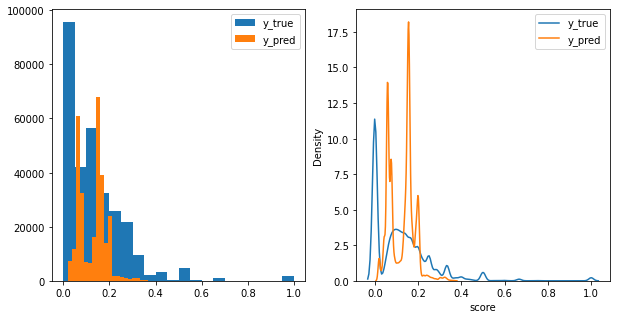

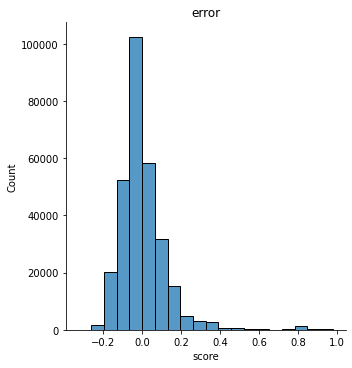

In [31]:
ltr_metrics.show_metrics('train')

Reading metrics from /home/carlos/MasterDS/tfm/models/ltr_gbt/e735c66e57/validation_metrics.pickle
mse : 0.014770326759540677
mae : 0.08330734495334782
r2 : 0.19789507181638788


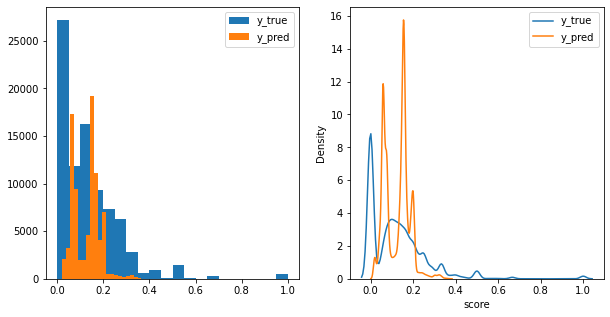

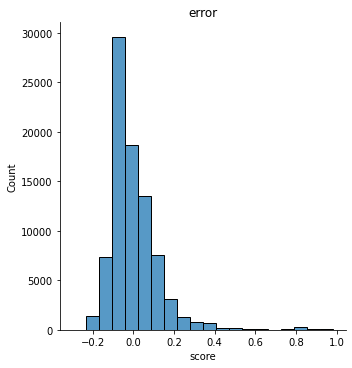

In [32]:
ltr_metrics.show_metrics('validation')